# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
from collections import namedtuple
pd.set_option("display.max_rows",35)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(125973, 124)

In [4]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Attack','is_Normal']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]

    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)

    y_train = y_output.values
    y_test = y_test.values

preprocess.x_train.std()

0.99589320646770185

In [6]:
import tensorflow as tf
from tensorflow.contrib.legacy_seq2seq.python.ops.seq2seq import basic_rnn_seq2seq
from tensorflow.contrib.rnn import RNNCell, LSTMCell, MultiRNNCell


In [7]:
class network(object):
    
    input_dim = 122
    classes = 2
    hidden_encoder_dim = 122
    hidden_layers = 1
    latent_dim = 10

    hidden_decoder_dim = 122
    lam = 0.01
    
    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        hidden_decoder_dim = self.hidden_decoder_dim
        lam = self.lam
        
        with tf.variable_scope("Input"):
            self.x_input = tf.placeholder("float", shape=[None, 1, input_dim])
            self.y_input_ = tf.placeholder("float", shape=[None, 1, classes])
            self.keep_prob = tf.placeholder("float")
            self.x_list = tf.unstack(self.x_input, axis= 1)
            self.y_list_ = tf.unstack(self.y_input_, axis = 1)
            self.y_ = self.y_list_[0]
            
            #GO = tf.fill((tf.shape(self.x)[0], 1), 0.5)
            
            #y_with_GO = tf.stack([self.y_, GO])
            
        with tf.variable_scope("lstm"):
            multi_cell = MultiRNNCell([LSTMCell(input_dim) for i in range(hidden_layers)] )
            
            self.y, states = basic_rnn_seq2seq(self.x_list, self.y_list_, multi_cell)
            #self.y = tf.slice(self.y, [0, 0], [-1,2])
            
            #self.out = tf.squeeze(self.y)
            
            self.y = tf.layers.dense(self.y[0], classes, activation = tf.nn.softmax)
        with tf.variable_scope("Loss"):
            
            self.regularized_loss = tf.losses.mean_squared_error(self.y_, self.y)
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=1e-2
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

batch_iterations = 200

x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                          preprocess.y_train, 
                                                                          test_size=0.1)
batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                           batch_iterations)
                                                                          
for i in batch_indices:
    print(x_train[i,np.newaxis,:])
    print(y_train[i,np.newaxis,:])

In [10]:
import collections

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score'])

    predictions = {}

    results = []
    best_acc = 0
    
    def train(epochs, net, h,f):
        batch_iterations = 200
    
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())

            for epoch in range(1, (epochs+1)):
                x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                          preprocess.y_train, 
                                                                          test_size=0.1)
                batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                           batch_iterations)
                                                                          
                for i in batch_indices:
                    
                    _, train_loss = sess.run([net.train_op, net.regularized_loss], #net.summary_op
                                                          feed_dict={net.x_input: x_train[i,np.newaxis,:], 
                                                                     net.y_input_: y_train[i,np.newaxis,:], 
                                                                     net.keep_prob:1})
                    #summary_writer_train.add_summary(summary_str, epoch)
                    if(train_loss > 1e9):
                        print("Step {} | Training Loss: {:.6f}".format(epoch, train_loss))
                    

                valid_accuracy,valid_loss = sess.run([net.tf_accuracy, net.regularized_loss], #net.summary_op 
                                                      feed_dict={net.x_input: x_valid[:,np.newaxis,:], 
                                                                 net.y_input_: y_valid[:,np.newaxis,:], 
                                                                 net.keep_prob:1})
                #summary_writer_valid.add_summary(summary_str, epoch)

                if epoch % 1 == 0:
                    print("Step {} | Training Loss: {:.6f} | Test Loss: {:.6f} | Test Accuracy: {:.6f}".format(epoch, train_loss, valid_loss, valid_accuracy))

            accuracy, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, 
                                                           net.pred, 
                                                           net.actual, net.y], 
                                                          feed_dict={net.x_input: preprocess.x_test[:,np.newaxis,:], 
                                                                     net.y_input_: preprocess.y_test[:,np.newaxis,:], 
                                                                     net.keep_prob:1})


            print("Accuracy on Test data: {}".format(accuracy))
            
            curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1]})
            Train.predictions.update({"{}_{}_{}".format(epochs,f,h):curr_pred})
            
            if accuracy > Train.best_acc:
                Train.best_acc = accuracy
                Train.pred_value = pred_value
                Train.actual_value = actual_value
                Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)
                #net.saver.save(sess, "dataset/epochs_{}_hidden layers_{}_features count_{}".format(epochs,h,f))
            Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))
            

In [11]:
import itertools
class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]
    features_arr = [4, 8, 16, 32]
    hidden_layers_arr = [2, 4, 6]

    epochs = [20]
    
    for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
        print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
        n = network(2,h,f)
        n.build_layers()
        Train.train(e, n, h,f)
        

Current Layer Attributes - epochs:20 hidden layers:2 features count:4
Step 1 | Training Loss: 0.000001 | Test Loss: 0.000875 | Test Accuracy: 0.999127
Step 2 | Training Loss: 0.000024 | Test Loss: 0.000957 | Test Accuracy: 0.998889
Step 3 | Training Loss: 0.000000 | Test Loss: 0.000874 | Test Accuracy: 0.999127
Step 4 | Training Loss: 0.000000 | Test Loss: 0.000397 | Test Accuracy: 0.999603
Step 5 | Training Loss: 0.000000 | Test Loss: 0.000556 | Test Accuracy: 0.999444
Step 6 | Training Loss: 0.001767 | Test Loss: 0.001032 | Test Accuracy: 0.998968
Step 7 | Training Loss: 0.000000 | Test Loss: 0.000318 | Test Accuracy: 0.999682
Step 8 | Training Loss: 0.000000 | Test Loss: 0.000476 | Test Accuracy: 0.999524
Step 9 | Training Loss: 0.000000 | Test Loss: 0.000477 | Test Accuracy: 0.999524
Step 10 | Training Loss: 0.000000 | Test Loss: 0.000397 | Test Accuracy: 0.999603
Step 11 | Training Loss: 0.000000 | Test Loss: 0.000318 | Test Accuracy: 0.999682
Step 12 | Training Loss: 0.000000 | T

Step 16 | Training Loss: 0.000000 | Test Loss: 0.000953 | Test Accuracy: 0.999047
Step 17 | Training Loss: 0.003534 | Test Loss: 0.001826 | Test Accuracy: 0.998174
Step 18 | Training Loss: 0.000000 | Test Loss: 0.001270 | Test Accuracy: 0.998730
Step 19 | Training Loss: 0.000000 | Test Loss: 0.001349 | Test Accuracy: 0.998651
Step 20 | Training Loss: 0.001767 | Test Loss: 0.001429 | Test Accuracy: 0.998571
Accuracy on Test data: 0.9861160516738892
Current Layer Attributes - epochs:20 hidden layers:4 features count:8
Step 1 | Training Loss: 0.014138 | Test Loss: 0.012775 | Test Accuracy: 0.987220
Step 2 | Training Loss: 0.012326 | Test Loss: 0.013728 | Test Accuracy: 0.986268
Step 3 | Training Loss: 0.019437 | Test Loss: 0.013259 | Test Accuracy: 0.986744
Step 4 | Training Loss: 0.003570 | Test Loss: 0.003678 | Test Accuracy: 0.996269
Step 5 | Training Loss: 0.008816 | Test Loss: 0.002896 | Test Accuracy: 0.997063
Step 6 | Training Loss: 0.003535 | Test Loss: 0.003575 | Test Accuracy: 0

Step 10 | Training Loss: 0.011542 | Test Loss: 0.009639 | Test Accuracy: 0.989760
Step 11 | Training Loss: 0.016302 | Test Loss: 0.009798 | Test Accuracy: 0.989840
Step 12 | Training Loss: 0.008870 | Test Loss: 0.009132 | Test Accuracy: 0.989681
Step 13 | Training Loss: 0.022026 | Test Loss: 0.010958 | Test Accuracy: 0.988411
Step 14 | Training Loss: 0.015188 | Test Loss: 0.011386 | Test Accuracy: 0.988014
Step 15 | Training Loss: 0.011669 | Test Loss: 0.014885 | Test Accuracy: 0.983331
Step 16 | Training Loss: 0.013022 | Test Loss: 0.012898 | Test Accuracy: 0.987141
Step 17 | Training Loss: 0.049470 | Test Loss: 0.057711 | Test Accuracy: 0.942292
Step 18 | Training Loss: 0.064950 | Test Loss: 0.060126 | Test Accuracy: 0.939752
Step 19 | Training Loss: 0.044118 | Test Loss: 0.050733 | Test Accuracy: 0.948960
Step 20 | Training Loss: 0.003728 | Test Loss: 0.003824 | Test Accuracy: 0.995634
Accuracy on Test data: 0.8834723234176636
Current Layer Attributes - epochs:20 hidden layers:6 fea

In [12]:
df_results = pd.DataFrame(Train.results)

In [13]:
df_results.sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score
6,20,16,4,1.000000,0.999512
2,20,16,2,0.999365,0.998847
1,20,8,2,0.998889,0.998137
10,20,16,6,0.999365,0.995697
8,20,4,6,0.999603,0.986959
4,20,4,4,0.998571,0.986116
3,20,32,2,0.999603,0.981991
0,20,4,2,0.999444,0.980394
5,20,8,4,0.996587,0.978487
7,20,32,4,0.987220,0.890924


In [14]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_lstm_nsl_kdd_predictions.pkl")
df_results.to_pickle("dataset/tf_lstm_nsl_kdd_scores.pkl")

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, preprocess.output_columns_2labels, normalize = True,
                         title = Train.best_parameters)

Normalized confusion matrix
[[ 1.      0.    ]
 [ 0.0011  0.9989]]


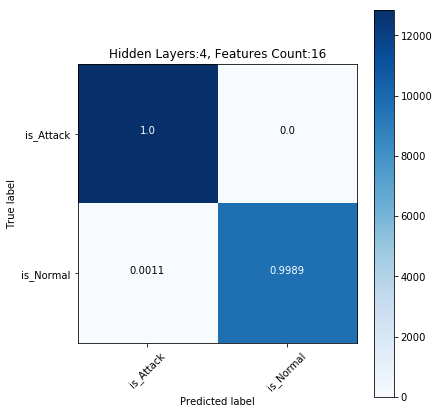

In [16]:
plot(actual_value = Train.actual_value, pred_value = Train.pred_value)

In [18]:
#4.5 GB
pd.Series(Train.pred_value).to_csv('LSTM_prediction_values.csv')